In [251]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [252]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [253]:
t_max = 50
epsilon = 1e-6
N_t = 150

l=1.0

# Para subamortiguado 0<zeta<1
# Para criticamente amortiguado zeta=1
# Para sobreamortiguado zeta > 1

m = 1
k = 5
c = 0.7

zeta = c/(2*np.sqrt(2*m*k))
w_0 = np.sqrt(k/m)
w_d = w_0*np.sqrt(1-zeta**2)

lr = 2e-3
layers = 2
neuronas = 32
epocs = 100_000

In [254]:
# Modelo

class FunAct(nn.Module):
    def forward(self,x):
        return torch.tanh(x)


class MLP(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, width=neuronas, depth=layers):
        super().__init__()
        capas = [nn.Linear(in_dim, width), FunAct()]
        for _ in range(depth - 1):
            capas += [nn.Linear(width, width), FunAct()]
        capas +=[nn.Linear(width, out_dim)]
        self.net=nn.Sequential(*capas)    

    def forward(self, x):
        return self.net(x)

In [255]:
u = MLP().to(device)

In [256]:
def D(y, x):
    return torch.autograd.grad(y,x, torch.ones_like(y), retain_graph = True, create_graph= True)[0]
def R(u,t):
    
    

    u_t = D(u,t)
    u_tt = D(u_t,t)

    return k*u + c*u_t + m*u_tt

def u_forward(t):
    return u(t)

In [257]:
def muestreo(N):
    return torch.rand(N, 1, device=device)*(t_max - epsilon) + epsilon

In [258]:
optimizador = torch.optim.Adam(u.parameters(), lr)

In [259]:
loss_valores = []

for step in range(epocs):

    optimizador.zero_grad()

    t_i = muestreo(N_t).clone().detach().requires_grad_()
    #u_i = u_forward(t_i)
    R_i = R(u(t_i),t_i)
    
    # Condiciones de borde (CB): u(0) = l
    t0 = torch.tensor([[0.0]], device=device, requires_grad=True)

    t_f = torch.tensor([[1.0]], device=device, requires_grad=True)*t_max

    u_t0 = D(u(t0),t0)
    
    u0 = u(t0)  # debería valer l
    
    cb1_loss = (u(t_f)**2).mean() 

    # Definir la pérdida asociada a esas condiciones
    ci1_loss = ((u0 - torch.tensor([[1.0]], device=device, requires_grad=False)*l)**2).mean() 

    ci2_loss = ((u_t0 - torch.tensor([[0.0]], device=device, requires_grad=False))**2).mean()


    loss = (R_i*R_i).mean() + ci1_loss + ci2_loss + cb1_loss

    loss_valores.append(loss.item())

    loss.backward()

    optimizador.step()

    if step % 200 == 0:
        print(f"step {step:4d} | loss {loss.item():.3e}")


step    0 | loss 5.952e-01
step  200 | loss 1.091e-01
step  400 | loss 3.464e-02
step  600 | loss 4.145e-02
step  800 | loss 3.188e-02
step 1000 | loss 1.253e-02
step 1200 | loss 2.424e-02
step 1400 | loss 2.090e-02
step 1600 | loss 2.834e-02
step 1800 | loss 2.114e-02
step 2000 | loss 2.882e-02
step 2200 | loss 1.679e-02
step 2400 | loss 2.514e-02
step 2600 | loss 1.857e-02
step 2800 | loss 1.451e-02
step 3000 | loss 1.494e-02
step 3200 | loss 2.417e-02
step 3400 | loss 9.592e-03
step 3600 | loss 2.272e-02
step 3800 | loss 1.446e-02
step 4000 | loss 1.351e-02
step 4200 | loss 1.381e-02
step 4400 | loss 2.026e-02
step 4600 | loss 7.657e-03
step 4800 | loss 5.346e-03
step 5000 | loss 1.517e-02
step 5200 | loss 1.487e-02
step 5400 | loss 1.082e-02
step 5600 | loss 1.296e-02
step 5800 | loss 1.041e-02
step 6000 | loss 1.084e-02
step 6200 | loss 9.530e-03
step 6400 | loss 1.366e-02
step 6600 | loss 1.033e-02
step 6800 | loss 2.157e-02
step 7000 | loss 2.233e-02
step 7200 | loss 1.128e-02
s

Text(0.5, 1.0, 'loss')

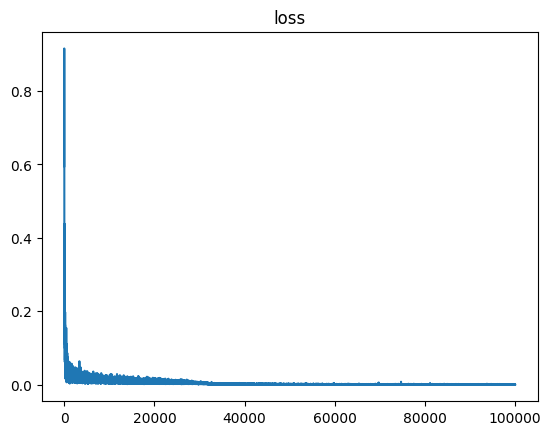

In [260]:
plt.plot(loss_valores)
plt.title('loss')

Text(0, 0.5, 'Loss')

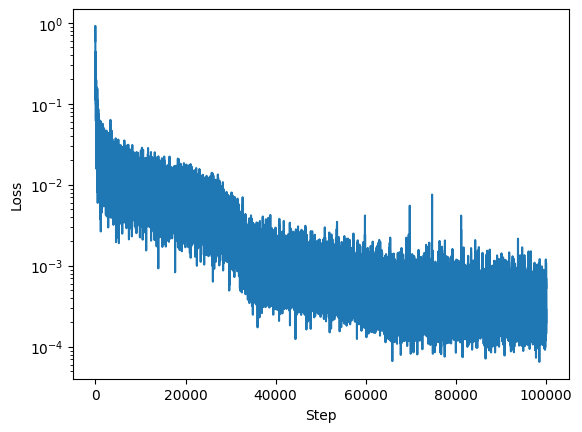

In [261]:
import matplotlib.pyplot as plt
plt.plot(loss_valores)
plt.yscale('log')  # si baja exponencialmente
plt.xlabel("Step"); plt.ylabel("Loss")

In [262]:
def u_sub_amortiguado(t):
    A = l
    B = zeta*w_0*l/w_d
    return np.exp(-zeta*w_0*t)*(A*np.cos(w_d*t) -B* np.sin(w_d*t))


def u_critico(t):
    A = l
    B = w_0*l
    return np.exp(-w_0*t)*(A + B*t)

def u_sobre_amortiguado_0(t):
    r1 = -w_0*(zeta - np.sqrt(zeta**2 - 1) )
    r2 = -w_0*(zeta + np.sqrt(zeta**2 - 1) )
    C  = -r2*l/(r1 - r2)
    D  =  r1*l/(r1 - r2)
    return C*np.exp(r1*t) + D*np.exp(r2*t)

def u_sobre_amortiguado(t, w0=w_0, z=zeta, ell=l):
    # z > 1
    s = z*z - 1.0
    if s <= 0:
        # No válido para sobre-amortiguado
        return np.full_like(t, np.nan, dtype=float)
    root = np.sqrt(s)
    r1 = -w0*(z - root)   # menos negativo ⇒ modo lento
    r2 = -w0*(z + root)   # más negativo ⇒ modo rápido
    C  = -r2 * ell / (r1 - r2)
    D  =  r1 * ell / (r1 - r2)   # <- CORREGIDO: r1, no r2
    return C*np.exp(r1*t) + D*np.exp(r2*t)


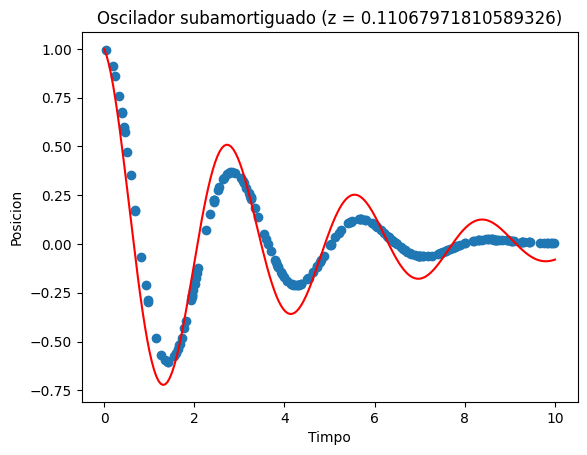

In [263]:
with torch.no_grad():
    f = torch.rand(200, 1, device=device)*(10 - epsilon) + epsilon
    t_i = f.clone().detach().requires_grad_()
    t_vals = t_i.detach().cpu().numpy()
    u_vals = u(t_i).detach().cpu().numpy()
    u_vals = u_vals.ravel().tolist()


t_poblado = np.linspace(0,10,len(t_vals))

if zeta < 1:
    plt.title('Oscilador subamortiguado'+' (z = '+str(zeta)+')')
    plt.plot(t_poblado,u_sub_amortiguado(t_poblado),'red')
elif zeta >1:
    plt.title('Oscilador sobreamortiguado'+' (z = '+str(zeta)+')')
    plt.plot(t_poblado,u_sobre_amortiguado(t_poblado),'green')
else:
    plt.title('Oscilador criticamente amortiguado'+' (z = '+str(zeta)+')')
    plt.plot(t_poblado,u_critico(t_poblado),'orange')

plt.scatter(t_vals,u_vals)
plt.xlabel('Timpo')
plt.ylabel('Posicion')
plt.show()